# Libraries

In [11]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler

# Loading the Files

Download the csv files into the `data/` directory.

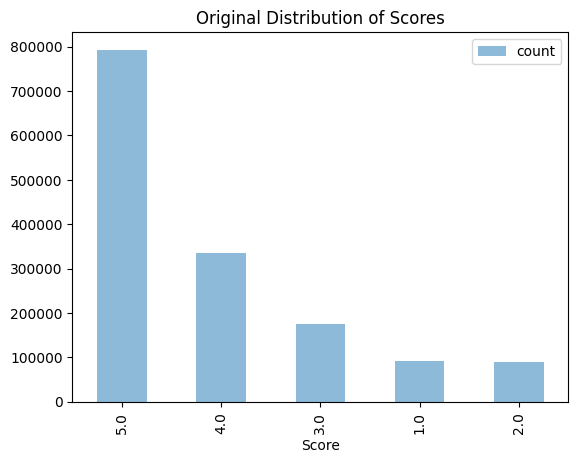

Number of 1-star reviews: 89000
Number of 2-star reviews: 89000
Number of 3-star reviews: 89000
Number of 4-star reviews: 89000
Number of 5-star reviews: 89000


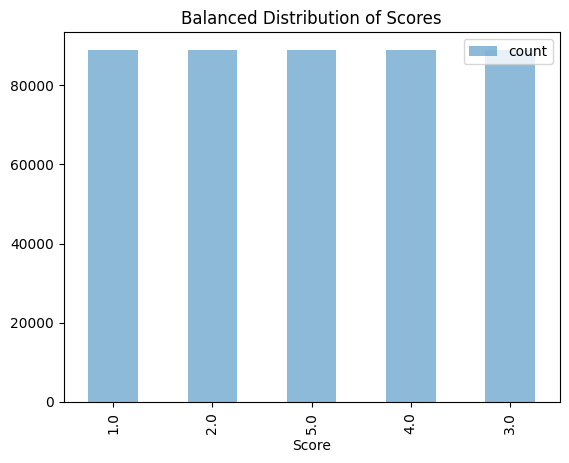


Balanced training set shape: (657192, 9)
Balanced training set is ready for use!

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("data/train.csv")
testingSet = pd.read_csv("data/test.csv")

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Original Distribution of Scores")
plt.show()

#here we want to balance the training set!! this is because the training set is too big and i just dont 
#want to deal, so i am going to make it smaller and downsize the 5 star reviews becaused there are too many of them!! :)


# Collect all reviews in a list

# Define the review threshold for each star rating (e.g., 10,000 reviews per rating)
review_threshold = 89000

# Step 1: Start with all Ids from the testingSet, but instead of concatenating directly, collect reviews in a list
collected_reviews = []

# Step 2: Include all reviews from testingSet Ids first
for id_value in testingSet['Id']:
    # Get all reviews for this Id from the train set
    id_reviews = trainingSet[trainingSet['Id'] == id_value]
    collected_reviews.append(id_reviews)

# Step 3: For each star rating (1 to 5 stars), add reviews from the trainingSet until the threshold is met
for rating in [1, 2, 3, 4, 5]:
    rating_reviews = trainingSet[trainingSet['Score'] == rating]
    
    # Count how many reviews for this rating are already in the balanced set
    current_count = sum([df[df['Score'] == rating].shape[0] for df in collected_reviews])
    
    # Calculate how many more reviews are needed to reach the threshold
    reviews_needed = review_threshold - current_count
    
    if reviews_needed > 0:

        if reviews_needed > len(rating_reviews):
            reviews_needed = len(rating_reviews)

        # Sample additional reviews from the remaining trainingSet for this rating
        additional_reviews = rating_reviews.sample(reviews_needed, replace=False, random_state=42)
        
        # Add the sampled reviews to the collected reviews
        collected_reviews.append(additional_reviews)

# Step 4: Once all reviews are collected, concatenate them into one DataFrame
balanced_training_set = pd.concat(collected_reviews).sample(frac=1, random_state=42).reset_index(drop=True)

# Loop through each star rating (1 to 5 stars) and print the number of reviews
for rating in [1, 2, 3, 4, 5]:
    review_count = balanced_training_set[balanced_training_set['Score'] == rating].shape[0]
    print(f"Number of {rating}-star reviews: {review_count}")


# Step 5: Plot the distribution of ratings in the final balanced set
balanced_training_set['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Balanced Distribution of Scores")
plt.show()

# Step 6: Final output
print()
print("Balanced training set shape:", balanced_training_set.shape)
print("Balanced training set is ready for use!")


print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

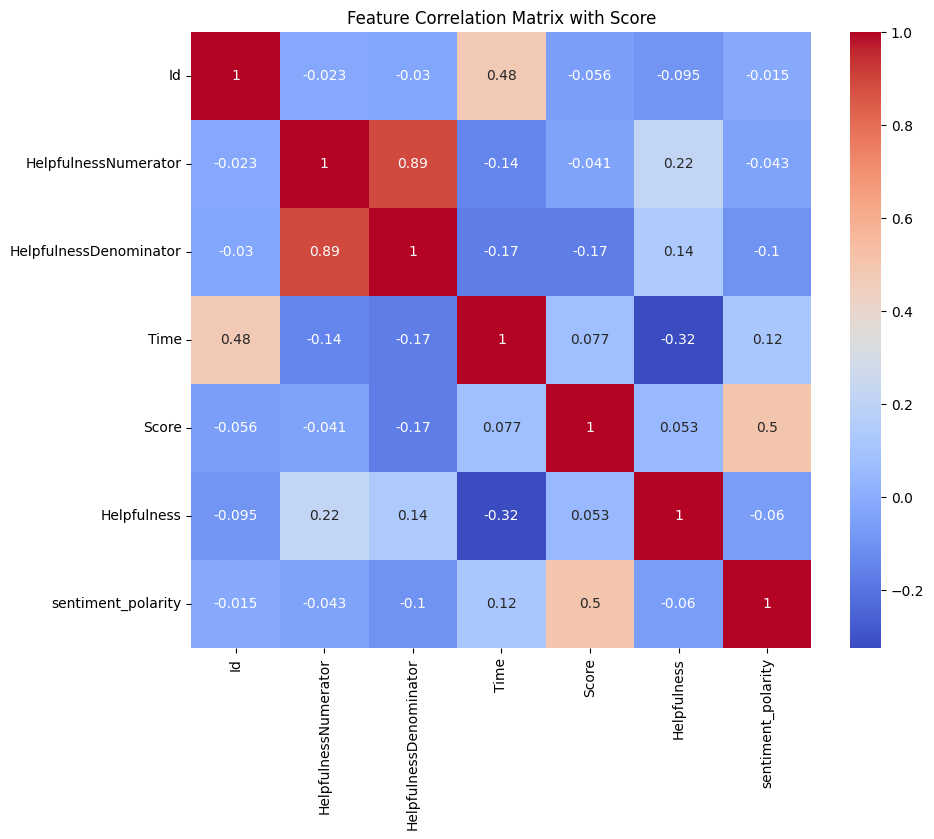

train shape: (657192, 11)
testingSet shape: (212192, 2)
First few Ids in train:
        Id
0  1248981
1   175813
2   223925
3  1344283
4   305114
First few Ids in testingSet:
        Id
0  1323432
1  1137299
2  1459366
3   931601
4  1311995
Data type of Id in train: int64
Data type of Id in testingSet: int64
Number of common Ids between train and testingSet: 212192
X_submission shape after merge: (212192, 12)
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   223925  6300217027   AVTVARULU85KO                     0   
1  1344283  B003FSTN52  A1VFTT1ZX19UF3                     0   
2   766206  B0000AQS0F   ATJZKQJA9CJ35                     0   
3  1416668  B004LWZW8I  A3QCC2MD5C8RST                     1   
4   227578  6300248143  A28GRFVAA4DU5P                     3   

   HelpfulnessDenominator        Time  \
0                       0  1377302400   
1                       1  1371168000   
2                       0  1396742400   
3                       2  1331078400 

In [17]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Sentiment polarity using TextBlob, This feature will have values ranging from -1 (very negative) to 1 (very positive), with 0 being neutral.
    # ie -1 means theyre super upset, 0 means theyre neutral, 1 means theyre hype! 
    df['sentiment_polarity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

    if 'Score' in df.columns:
        numeric_df = df.select_dtypes(include=[float, int])  # Select only numeric columns
        correlation_matrix = numeric_df.corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title("Feature Correlation Matrix with Score")
        plt.show()


    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(balanced_training_set)

    # **Debug: Check the shapes and ID columns in train and testingSet**
    print("train shape:", train.shape)
    print("testingSet shape:", testingSet.shape)
    # **Check the first few rows of the Id columns in both datasets**
    print("First few Ids in train:")
    print(train[['Id']].head())
    print("First few Ids in testingSet:")
    print(testingSet[['Id']].head())
    # **Check if the data types of the Id column are consistent**
    print("Data type of Id in train:", train['Id'].dtype)
    print("Data type of Id in testingSet:", testingSet['Id'].dtype)

    common_ids = set(train['Id']).intersection(set(testingSet['Id']))
    print(f"Number of common Ids between train and testingSet: {len(common_ids)}")


    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')

    # **Debug: Check the shape and contents of X_submission after merging**
    print("X_submission shape after merge:", X_submission.shape)
    print(X_submission.head())  # Inspect the first few rows

    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    
    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]
    
    print("Columns in X_train:")
    for col in X_train.columns:
        print(f"'{col}'")

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [6]:


# print("Columns in X_train:")
# for col in X_train.columns:
#     print(f"'{col}'")

# if 'Score' in X_train.columns:
#     X_train = X_train.drop(columns=['Score'])
# else:
#     print("'Score' column not found in X_train!")

# dont touch 
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
) 

# Feature Selection

In [7]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'sentiment_polarity']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Initialize the StandardScaler, so that when the distance is calculated for knn it works. 
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_select)

# Only transform the test and submission data (no fitting)
X_test_scaled = scaler.transform(X_test_select)

# Check if the submission dataset is empty before scaling
if X_submission_select.shape[0] > 0:
    X_submission_scaled = scaler.transform(X_submission_select)
else:
    print("X_submission_select is empty, skipping scaling for submission data.")


# Model Creation

In [15]:
# # Learn the model
# model = KNeighborsClassifier(n_neighbors=15).fit(X_train_scaled, Y_train)

# # Predict the score using the model
# Y_test_predictions = model.predict(X_test_scaled)
# dont touch abouve 

# Define a range of values for k, jumping by 3 each time
param_grid = {'n_neighbors': list(range(1, 30, 3))}  # Odd values from 1 to 29, stepping by 3

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV with cross-validation and enable parallel processing
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='f1_weighted', return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_scaled, Y_train)

# Print each k value and its corresponding mean cross-validated score
print("Cross-validated scores for each k value:")
for mean_score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(f"k = {params['n_neighbors']}, F1-weighted score = {mean_score:.4f}")

# Retrieve the best model and optimal k value
best_k = grid_search.best_params_['n_neighbors']
print("\nOptimal number of neighbors:", best_k)

# Train the model using the best k found by grid search
best_knn_model = grid_search.best_estimator_

# Predict on the test set
Y_test_predictions = best_knn_model.predict(X_test_scaled)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross-validated scores for each k value:
k = 1, F1-weighted score = 0.3225
k = 4, F1-weighted score = 0.3381
k = 7, F1-weighted score = 0.3555
k = 10, F1-weighted score = 0.3671
k = 13, F1-weighted score = 0.3727
k = 16, F1-weighted score = 0.3780
k = 19, F1-weighted score = 0.3809
k = 22, F1-weighted score = 0.3831
k = 25, F1-weighted score = 0.3848
k = 28, F1-weighted score = 0.3869

Optimal number of neighbors: 28


# Model Evaluation

Accuracy on testing set =  0.3830831460674157


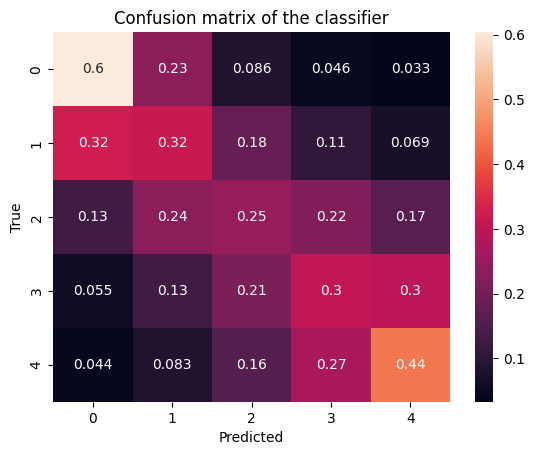

In [9]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [8]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)